In [1]:
from pymongo import MongoClient
import pandas as pd
from parse_clean_store import (parse_route_page, parse_user)
from bs4 import BeautifulSoup
from matrix_recommender_prep import (clean_ratings, cold_start, update_df)
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [35]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7fa4c45c5750>,
 <pyspark.context.SparkContext at 0x7fa4f19738d0>)

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client.ratings_collection
ratings_collection = db.ratings_collection
raw_data = ratings_collection.find()
df_ratings = pd.DataFrame(list(raw_data))
df_ratings.head()

,_id,rating,route,username
0,58c87f8c40b44102a84aedfb,[1],30(1) Feet of Pleasure,[adam winslow ]
1,58c87f9d40b44102a84aee01,[1],41 Feet of Pain,[adam winslow ]
2,58c87fac40b44102a84aee07,"[1, 1, 1, 1]",5.5 Crack,"[CHopwood , Trevor. , Rickedge , Oscar Edge ]"
3,58c87fb440b44102a84aee0d,"[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",5.6 crack,"[Bianca P , Sandeep Kumar , Mike Brady , Tom B..."
4,58c87fbf40b44102a84aee13,"[2, 2, 2, 2, 1, 1, 1, 1, 1]",5.6 Dihedral,"[Jason Killgore , sqwirll , Dave Leydet , fort..."


In [93]:
ratings_df_pd, _ = update_df(df_ratings)
ratings_df_pd.head()

ValueError: too many values to unpack

In [32]:
# Convert to a Spark DataFrame
ratings_df = spark.createDataFrame(ratings_df_pd)

In [11]:
# Check to see we built the DataFrame
ratings_df

DataFrame[username: bigint, route: bigint, rating: bigint]

In [12]:
# Take a look at the entries in the DataFrame
ratings_df.show(5)

+--------+-----+------+
|username|route|rating|
+--------+-----+------+
|    1705|   28|     1|
|    1705|   29|     1|
|     281|   34|     1|
|    1620|   34|     1|
|    1346|   34|     1|
+--------+-----+------+
only showing top 5 rows



In [43]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)

In [14]:
# Check to see our split worked
train.count(), test.count()

(23756, 6014)

In [15]:
als_model = ALS(userCol='username',
                itemCol='route',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

In [16]:
recommender = als_model.fit(train)

In [37]:
path = '/home/david/work/project/Rock-Climbing-Route-Recommender/src/alsmodel'

In [18]:
recommender.save(path)

In [38]:
recommender = ALSModel.load(path)

In [21]:
# Build a single row DataFrame
data = [(1, 100)]
columns = ('username', 'route')
one_row_spark_df = spark.createDataFrame(data, columns)

In [22]:
# Check that it worked
one_row_spark_df.show()

+--------+-----+
|username|route|
+--------+-----+
|       1|  100|
+--------+-----+



In [23]:
# Get the factors for user 1 and route 100
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [24]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [25]:
# Manually (sorta) calculate the predicted rating
np.dot(user_factors, item_factors)

2.2541360503189787

In [26]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-----+----------+
|username|route|prediction|
+--------+-----+----------+
|       1|  100|  2.254136|
+--------+-----+----------+



In [27]:
# Let's take a look all the user factors
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  5|[0.940962, 0.1725...|
| 15|[0.52034414, 0.01...|
| 25|[0.9974378, 0.0, ...|
| 35|[0.49017465, 0.68...|
| 45|[0.5604168, 0.280...|
| 55|[0.30448154, 0.73...|
| 65|[0.65507495, 0.37...|
| 75|[1.5325257, 0.532...|
| 85|[0.9759228, 0.378...|
|105|[0.39770216, 0.18...|
|115|[0.8308178, 0.798...|
|125|[0.4698225, 0.026...|
|135|[0.0062884125, 0....|
|145|[0.69312584, 0.12...|
|155|[0.53147763, 0.43...|
|165|[0.47684115, 0.30...|
|175|[0.63305855, 0.12...|
|185|[0.61809736, 0.77...|
|195|[0.13990396, 0.08...|
|205|[0.053322148, 0.1...|
+---+--------------------+
only showing top 20 rows



In [44]:
# Make predictions for the whole test set
predictions = recommender.transform(test)

In [45]:
type(recommender)

pyspark.ml.recommendation.ALSModel

In [46]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [56]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [57]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [49]:
predictions_df.describe()

,username,route,rating,prediction,squared_error
count,6014.000000,6014.000000,6014.000000,6014.000000,6.014000e+03
mean,1060.730961,1783.611074,2.703026,2.538594,5.056158e-01
std,599.803735,1002.985254,0.899730,0.690687,8.298224e-01
min,0.000000,0.000000,0.000000,0.000000,3.356547e-07
25%,568.000000,899.250000,2.000000,2.051087,5.462727e-02
50%,1069.000000,1805.000000,3.000000,2.597881,2.069278e-01
75%,1619.750000,2668.000000,3.000000,2.995571,5.722123e-01
max,2064.000000,3557.000000,4.000000,4.765341,1.600000e+01


In [50]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.71106669501393183

In [51]:
# see comparision to just average rating
test_df = test.toPandas()
test_df['prediction'] = train_df['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
test_df.head()

,username,route,rating,prediction,squared_error
0,0,20,2,2.712283,0.507347
1,8,124,3,2.712283,0.082781
2,8,167,2,2.712283,0.507347
3,8,396,2,2.712283,0.507347
4,8,1214,3,2.712283,0.082781


In [52]:
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

0.8997025214334432

In [53]:
# see comparision to average rating per route
test_df = test.toPandas()
for route in test_df['route']:
    test_df['prediction'] = train_df[train_df['route']==route]['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

1.1417639315072918

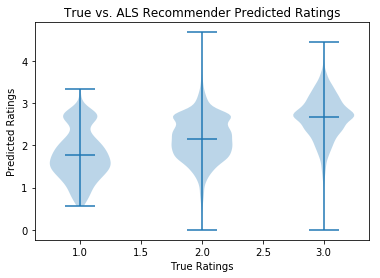

In [58]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 4)]
plt.violinplot(data, range(1,4), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [41]:
def get_route_list():
    client = MongoClient('mongodb://localhost:27017/')
    db = client.ratings_collection
    ratings_collection = db.ratings_collection
    collection = ratings_collection.find({"route": {'$exists' : True }})
    route_list = [d['route'].encode('utf-8').lower() for d in list(collection)]
    return route_list

def find_routes_in_list(routes, ratings):
    route_list = get_route_list()
    # drop caps
    routes = routes
    routes_numeric = []
    for route in routes:
        if route.lower() not in route_list:
            # remove from ratings and routes
            ratings.pop(routes.index(route))
            routes.remove(route)
        else:
            routes_numeric.append(route_list.index(route.lower()))
    return routes_numeric, ratings

def build_dataframe(routes, ratings):
    routes, ratings = find_routes_in_list(routes, ratings)
    # make up username
    data = [(66666, route, rating) for route, rating in zip(routes, ratings)]
    columns = ('username', 'route', 'rating')
    return spark.createDataFrame(data, columns)

routes = ['godzilla', 'Aires', 'Breakfast of Champions', 'cultureshock','bendsdsd']
ratings = [4,3,4,4,3]
predict_df = build_dataframe(routes, ratings)
recommender.transform(predict_df).show()

+--------+-----+------+----------+
|username|route|rating|prediction|
+--------+-----+------+----------+
|   66666|  955|     4|       NaN|
|   66666|  684|     3|       NaN|
|   66666| 1704|     4|       NaN|
|   66666| 3473|     4|       NaN|
+--------+-----+------+----------+



In [80]:
def get_route_list():
    client = MongoClient('mongodb://localhost:27017/')
    db = client.ratings_collection
    ratings_collection = db.ratings_collection
    collection = ratings_collection.find({"route": {'$exists' : True }})
    route_list = [d['route'].encode('utf-8').lower() for d in list(collection)]
    return route_list

def find_routes_in_list(routes):
    route_list = get_route_list()
    # drop caps
    routes = routes
    routes_numeric = []
    for route in routes:
        if route.lower() not in route_list:
            # remove from ratings and routes
            routes.remove(route)
        else:
            routes_numeric.append(route_list.index(route.lower()))
    return routes_numeric

def build_dataframe(routes, user):
    routes = find_routes_in_list(routes)
    # make up username
    data = [(1303, route) for route in routes]
    columns = ('username', 'route')
    return spark.createDataFrame(data, columns)

routes = ['godzilla', 'Aires', 'Breakfast of Champions', 'cultureshock','bendsdsd']
predict_df = build_dataframe(routes, ratings)
recommender.transform(predict_df).toPandas().fillna(train_df['rating'].mean())

,username,route,prediction
0,1303,955,1.822063
1,1303,684,2.712283
2,1303,1704,0.961419
3,1303,3473,2.286073


In [136]:
ratings_df_pd[ratings_df_pd['route'] == 1514]

,username,route,rating
10744,1059,1514,3
10745,2061,1514,3
10746,493,1514,3
10747,1783,1514,3
10748,1105,1514,3
10749,1278,1514,3
10750,669,1514,2
10751,1127,1514,2
10752,1008,1514,2
10753,332,1514,2


In [166]:
def update_df(df):
    row = 0
    username_list = []
    route_list = df['route'].unique().tolist()
    df_new = pd.DataFrame(columns=['username','route','rating'])
    for route, usernames, ratings in zip(df['route'], 
                                        df['username'],
                                        df['rating']):
        row += 1
        for username, rating in zip(usernames, ratings):
            if username.encode('utf-8') not in username_list:
                username_list.append(username.encode('utf-8'))
            row += 1
            df_new.loc[row, 'username'] = username.encode('utf-8')
            df_new.loc[row, 'rating'] = rating
            df_new.loc[row, 'route'] = route_list.index(route)
    # convert to catagorical the numerical
    df_new['username'] = df_new['username'].astype('category').cat.codes
    return df_new, username_list, route_list

df_new, username_list, routes = update_df(df_ratings)

In [169]:
routes.index('Godzilla')

926

In [170]:
df_new[df_new['route'] == 926]

,username,route,rating
9472,1016,926,4
9473,1388,926,4
9474,916,926,4
9475,802,926,4
9476,118,926,4
9477,1160,926,4
9478,1871,926,4
9479,1879,926,4
9480,182,926,4
9481,671,926,4
